In [1]:
import sys
print(sys.executable)

/home/mstryja/.conda/envs/stryja_sat/bin/python


In [2]:
import numpy as np

#Coviddetector
from coviddet.generator.dataset import Dataset
from coviddet.generator.dataloader import Dataloder
from coviddet.models.architecture import CovidClassifier

# Rest
import pandas as pd
from typing import List

# model definition
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception
from keras.layers import Input, Conv2D

# Preprocessing and additionals:
from sklearn.preprocessing import MinMaxScaler
from skimage import exposure
scaler = MinMaxScaler()

import cv2

import random

num_classes = 4

# matplotlib: 
import matplotlib.pyplot as plt

# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# Set GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

model_archive = '../trained_models/'

In [3]:
def decode_label(labels, classes):
    if labels.sum()==0:
        return 'Not Classified'
    for label, name in zip(labels, classes):
        if label==1:
            return str(name)

In [4]:
dataset_path = '../dataset.json'
dataset_images = '../../../covid_dataset/'

In [5]:
train, validation, test = Dataset.create_datasets(dataset_images, dataset_path, 0.1, 200)

dataset length: 6054
Evaluation Cases: 200
Train cases: 5269
Validation cases: 585


In [6]:
X = train[:9]

In [7]:
def balance_dataset(dataset, json_path):
    stats = np.asarray(dataset.analyse_dataset_labels())
    max_count = stats.min()
    print(max_count)
    new_files = []
    idx = i = j = k = 0
    while any((x<max_count for x in (i,j,k))):
    # while i < max_count and j < max_count and k < max_count:
        if np.array_equal(dataset.labels[idx], np.array([0,1,0,0], dtype=int)):
            if i > max_count:
                idx += 1
                continue
            new_files.append(dataset.images[idx])
            i += 1
            idx += 1
            continue
            
        elif np.array_equal(dataset.labels[idx], np.array([0,0,1,0], dtype=int)):
            if j > max_count:
                idx += 1
                continue
            new_files.append(dataset.images[idx])
            j += 1
            idx += 1
            continue
            
        elif np.array_equal(dataset.labels[idx], np.array([0,0,0,1], dtype=int)):
            if k > max_count:
                idx += 1
                continue
            new_files.append(dataset.images[idx])
            k += 1
            idx += 1
            continue
            
        else:
            new_files.append(dataset.images[idx])
            idx += 1
            continue
        
    return Dataset(new_files, json_path)
    
            

In [8]:
balanced_train = balance_dataset(train, dataset_path)

419.0


In [9]:
balanced_train.analyse_dataset_labels()

array([190., 419., 420., 420.])

In [10]:
X = balanced_train[:9]

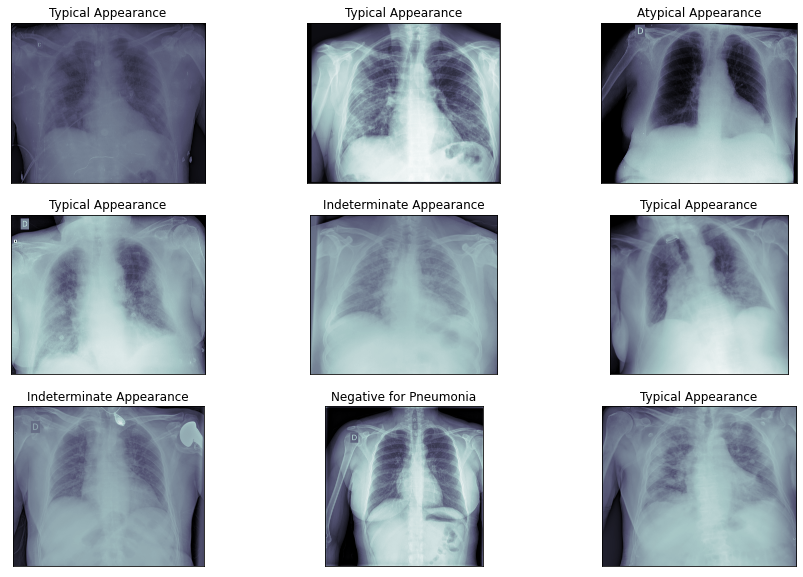

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
row = col = 0
for x in X:
    if col==3:
        row+=1
        col=0
    title = decode_label(x[1], balanced_train.CLASSES)
    axs[row, col].imshow(x[0], cmap=plt.cm.bone)
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])
    axs[row, col].set_title(title, fontsize=12)
    col+=1

In [12]:
train.analyse_dataset_labels()

array([ 419.,  905., 1470., 2475.])

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

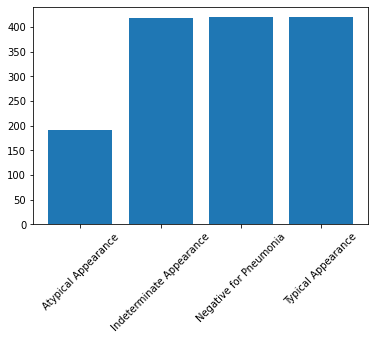

In [13]:
plt.bar(balanced_train.CLASSES, height=balanced_train.analyse_dataset_labels())
plt.xticks(rotation=45)

In [14]:
train_gen = Dataloder(balanced_train, batch_size=16, preprocessing='MinMax', shuffle=True, expanddims=True)
valid_gen = Dataloder(balanced_train, batch_size=8, preprocessing='MinMax', shuffle=False, expanddims=True)

In [15]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [16]:
classifier = CovidClassifier()

2022-01-24 16:15:28.407623: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-24 16:15:28.793876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38414 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


512.0
256.0
128.0
64.0
32.0
16.0
8.0
4.0


In [17]:
metrics = [keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None), 
                        keras.metrics.Precision(name="precision"), 
                        keras.metrics.Recall(name="recall")]

classifier.compile(optimizer=optim,
                     loss='hinge',# keras.losses.BinaryCrossentropy(), # default from_logits=False
                     metrics=metrics)

In [18]:
classifier.dense_shapes

ListWrapper([1024, 512, 256, 128, 64, 32, 16, 8])

In [19]:
history_custom = classifier.fit(train_gen,
                                  validation_data=valid_gen, 
                                  epochs=4)

2022-01-24 16:15:41.847613: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-01-24 16:15:42.343353: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


Epoch 1/4
90/90 [==============================] - 535s 6s/step - loss: 1.1103 - categorical_accuracy: 0.3069 - precision: 0.3022 - recall: 0.1910 - val_loss: 1.1080 - val_categorical_accuracy: 0.2887 - val_precision: 0.2887 - val_recall: 0.2887
Epoch 2/4
90/90 [==============================] - 502s 6s/step - loss: 1.1082 - categorical_accuracy: 0.2854 - precision: 0.2848 - recall: 0.2840 - val_loss: 1.1071 - val_categorical_accuracy: 0.2887 - val_precision: 0.2887 - val_recall: 0.2887
Epoch 3/4
90/90 [==============================] - 504s 6s/step - loss: 1.1060 - categorical_accuracy: 0.2854 - precision: 0.2872 - recall: 0.2840 - val_loss: 1.1206 - val_categorical_accuracy: 0.2887 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/4
90/90 [==============================] - 500s 6s/step - loss: 1.1090 - categorical_accuracy: 0.2854 - precision: 0.2877 - recall: 0.2743 - val_loss: 1.1167 - val_categorical_accuracy: 0.2887 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


In [20]:
test_datagenerator = Dataloder(test, batch_size=1, preprocessing='MinMax', shuffle=False, expanddims=True)
scores = classifier.evaluate(test_datagenerator)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.name, value))

200/200 [==============================] - 42s 210ms/step - loss: 1.1198 - categorical_accuracy: 0.1750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 1.1198
mean categorical_accuracy: 0.175
mean precision: 0.0
mean recall: 0.0


[199, 11, 121, 184, 33, 126]
[[0.14459994 0.39052317 0.20168637 0.26319057]]
[[0. 1. 0. 0.]]
[[0.1451242  0.38964763 0.20195036 0.2632778 ]]
[[0. 1. 0. 0.]]
[[0.1440843  0.39142737 0.20140533 0.26308295]]
[[0. 1. 0. 0.]]
[[0.14492537 0.39000723 0.20188165 0.2631857 ]]
[[0. 1. 0. 0.]]
[[0.14516625 0.38955745 0.2019363  0.26334   ]]
[[0. 1. 0. 0.]]
[[0.1441524  0.39145777 0.20154834 0.2628415 ]]
[[0. 1. 0. 0.]]


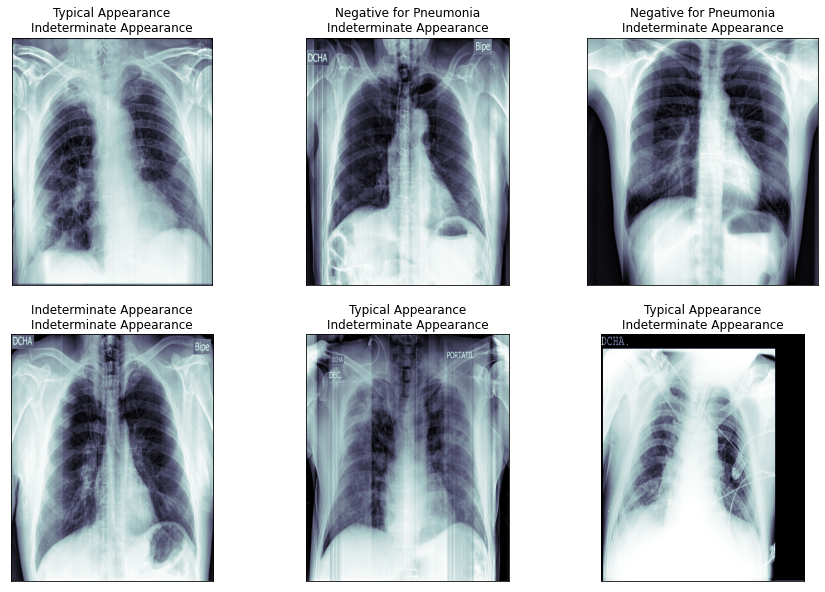

In [24]:
idxs = random.sample(range(0, len(test)), 6)
print(idxs)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

row = col = 0
for idx in idxs:
    if col==3:
        row += 1
        col = 0
    
    orig_shape = test[idx][0].shape
    # print(orig_shape)
    image, label = test_datagenerator[idx][0], test_datagenerator[idx][1]
    axs[row, col].imshow(cv2.resize(image[0], orig_shape, interpolation = cv2.INTER_AREA), cmap=plt.cm.bone)
    pred = classifier.predict(image)
    print(pred)
    pred[pred < pred.max()] = 0
    pred[pred==pred.max()] = 1
    print(pred)
    title = decode_label(label[0], test.CLASSES) + '\n' + decode_label(pred[0], test.CLASSES)
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])
    col+=1

In [40]:
classifier.name

'covid_classifier_2'

In [41]:
model_archive = '/home/mstryja/projects/master_thesis_covid/trained_models'

In [44]:
classifier.save_weights(os.path.join(model_archive, classifier.name, 'model_final_weights.h5'))

In [52]:
classifier_2 = CovidClassifier()
metrics = [keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None), 
                        keras.metrics.Precision(name="precision"), 
                        keras.metrics.Recall(name="recall")]

classifier_2.compile(optimizer=optim,
                     loss='hinge',# keras.losses.BinaryCrossentropy(), # default from_logits=False
                     metrics=metrics)

classifier_2.build(train_gen[0][0].shape)

512.0
256.0
128.0
64.0
32.0
16.0
8.0
4.0


In [53]:
classifier_2.load_weights(os.path.join(model_archive, classifier.name, 'model_final_weights.h5'))

In [54]:
scores = classifier_2.evaluate(test_datagenerator)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.name, value))

200/200 [==============================] - 35s 173ms/step - loss: 1.0050 - categorical_accuracy: 0.4900 - precision: 0.4900 - recall: 0.4900
Loss: 1.005
mean categorical_accuracy: 0.49
mean precision: 0.49
mean recall: 0.49
